# Course 5 - Personalized Real Estate Agent (HomeMatch)

In [ ]:
from langchain_openai import ChatOpenAI
from langchain_core.tools import create_retriever_tool, tool
from langchain_core.messages import HumanMessage, SystemMessage, RemoveMessage, AIMessage, ToolMessage
from langchain_core.output_parsers import PydanticOutputParser

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.prebuilt import ToolNode, InjectedState

from src.utils import get_vector_store, VECSTORE_PATH
from pydantic import BaseModel, Field

from typing import Annotated, Dict, List, Literal
from PIL import Image

import io

class AgentState(MessagesState):
    preferences: str = ""
    summary: str = ""

vecstore = get_vector_store(VECSTORE_PATH)

retriever_tool = create_retriever_tool(
    vecstore.as_retriever(),
    "retrieve_property_listings",
    "Queries and returns documents regarding property listings.",
)

@tool
def update_user_preferences(preferences: str, state: Annotated[Dict, InjectedState]):
    """Update the user preferences in the state"""
    
    state.update(dict(preferences=preferences))
    return "User preferences updated successfully."


tools = [retriever_tool, update_user_preferences]

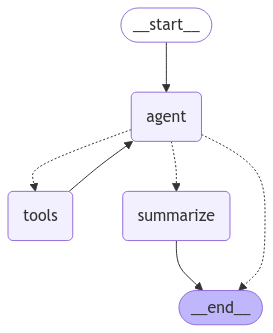

In [2]:
def agent(state: AgentState):
    """Call the model's agent with the current state"""

    model = ChatOpenAI(
        model="gpt-3.5-turbo", temperature=0.5, max_tokens=1000
    ).bind_tools(tools)

    house_preferences = state.get("preferences", "No preferences provided.")
    summary = state.get("summary", "No conversation summary provided.")

    system_prompt = f"""
You are a real estate agent with a passion for helping users find their ideal home. Be charismatic, friendly, and optimistic.

Probably, some details about the user won't be necessary, but it will be a nice touch to really know the user. For example, ask what their name is, if they have any kids or pets, and what their favorite color is. You might find this information useful to make great suggestions.

The System will keep a record of the user preferences and make it available to you in the **House Preferences** section below.
The System will keep a record of the conversation history available to you in the **Conversation Summary** section below.

**Your main goals are:**
- To know and update the user preferences based on your interactions.
- To offer the user relevant property listings based on their preferences.
- Present the most relevant property listings to the user when:
  - You think you have enough information.
  - The user preferences have been updated.

**House Preferences Rules:**
- It is strictly prohibited to save information unrelated to the property or the neighborhood.
- The preferences must describe the property, the price, budget, or neighborhood description.
- If no house preference has been provided, start by asking questions to the user.
- Update the preferences if the user shares new information that describes the property, the price, or neighborhood. Ensure to add new information to existing preferences rather than overriding them.
- Always confirm with the user before updating the preferences.

**Structured Questions to Ask:**
1. What is your budget for the property?
2. How many bedrooms and bathrooms are you looking for?
3. Do you have a preferred style or type of home?
4. Are there any specific amenities you require, such as a backyard or garage?
5. Do you prefer a specific neighborhood or proximity to certain locations like schools or parks?

**Retrieving Property Listings:**
- Once you have gathered enough information about the user's preferences, retrieve relevant property listings that match their criteria.
- Present these listings to the user in a clear and engaging manner.
- Ensure to highlight key features of each property that align with the user's preferences.

**House Preferences:**
{house_preferences}

**Conversation Summary:**
{summary}
"""

    system_message = SystemMessage(content=system_prompt)
    response = model.invoke([system_message] + state["messages"])

    # Remove tool messages and tool calls from the chat history
    remove_messages = [
        RemoveMessage(id=m.id)
        for m in state["messages"]
        if isinstance(m, ToolMessage) or (isinstance(m, AIMessage) and m.tool_calls)
    ]

    # Return the state update
    return dict(messages=remove_messages + [response])


def should_continue(state: AgentState) -> Literal["tools", "summarize", "__end__"]:
    """Condition to decide whether summarize, call a tool or end AI turn."""

    messages = state.get("messages")
    # Go to the tools node if the last message is a tool call
    if messages[-1].tool_calls:
        return "tools"

    # Go to summarize node if there are more than 6 messages in the history
    if 6 < len(messages):
        return "summarize"

    return END


def distill_interactions(state: AgentState):
    """Distill the interaction between the agent and the user."""

    class SummaryResponse(BaseModel):
        summary: List[str] = Field(
            description="list of distilled interaction key points"
        )

    model = ChatOpenAI(model="gpt-3.5-turbo", temperature=0.2, max_tokens=512)
    parser = PydanticOutputParser(pydantic_object=SummaryResponse)
    format_instructions = parser.get_format_instructions()

    system_prompt = f"""
This is a friendly conversation between an AI real estate agent and a user looking to buy a home.

Your task is to distill the main ideas of the interaction, keeping all relevant details about the conversation. Ensure that you capture any new preferences mentioned by the user, even if they have not been saved yet.

You will produce one or more ideas and follow the format instructions to the letter.

**Format Instructions:**
{format_instructions}
"""

    system_message = SystemMessage(content=system_prompt)

    response = model.invoke([system_message] + state["messages"])
    response: SummaryResponse = parser.invoke(response)

    existing_summary = state.get("summary", "")

    new_summary = [existing_summary] if existing_summary else []
    new_summary.extend(response.summary)

    # keep last two message and remove the rest
    remove_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]

    # Return the state updates.
    return dict(summary="\n".join(new_summary), messages=remove_messages)


memory = MemorySaver()
workflow = StateGraph(AgentState)

tool_node = ToolNode(tools)

workflow.add_node("agent", agent)
workflow.add_node("tools", tool_node)
workflow.add_node("summarize", distill_interactions)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", should_continue)
workflow.add_edge("tools", "agent")
workflow.add_edge("summarize", END)

graph = workflow.compile(checkpointer=memory)

graph_buffer = graph.get_graph().draw_mermaid_png()
Image.open(io.BytesIO(graph_buffer))

In [3]:
config = dict(configurable=dict(thread_id=4))

input_message = SystemMessage(content="The user has started the conversation.")

while True:
    for output in graph.stream(dict(messages=[input_message]), config):
        for key, value in output.items():
            for m in value["messages"]:
                m.pretty_print()

    user_input = ""
    while not user_input:
        user_input = input("User: ")
    
    if user_input == "/exit":
        break

    input_message = HumanMessage(content=user_input)
    input_message.pretty_print()

================================== Ai Message ==================================

Hello! I'm here to help you find your dream home. What's your name? Do you have any kids or pets? Also, what's your favorite color? Let's make this search personalized and fun for you! 😊
================================ Human Message =================================

Hello! My name is Agustin, I don't  have kids yet but we are planning to. Right now, I have a dog and I like blue and my wife likes funier colors.
================================== Ai Message ==================================

Nice to meet you, Agustin! Planning for the future with a growing family and a furry friend is exciting. Blue is a calming color, and it's great that you and your wife have different color preferences—it adds a fun touch to your home decor!

To start our search for your ideal home, could you please share your budget for the property? This will help us narrow down the options to find the perfect match for you.
=======

In [4]:
print(graph.get_state(config).values["summary"])

User's name is Agustin
Agustin doesn't have kids yet but is planning to
Agustin has a dog
Agustin likes blue, while his wife prefers funnier colors
Agustin's budget is $800,000
Agustin is looking for a 3-bedroom house with at least two bathrooms
Agustin likes modern houses but also considers ranch-style homes
